* Writer : Jesoon Kang, Chung-Ang University
* last-modified date : May 28, 2020

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import math
from IPython.display import display, Math, Latex
import os
import time
import datetime


file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

In [3]:
#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

In [4]:
#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

In [5]:
#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1


In [6]:
def sigmoid_grad(z):
    sig_value =  1.0 / (1.0 + np.exp(-z))
    return sig_value * (1 - sig_value)

In [7]:
def show_example(list_image,list_label) :
    f1 = plt.figure(1)
    
    for i in range(10):
        label       = list_label[i]
        im_vector   = list_image[:, i]
        im_matrix   = im_vector.reshape((size_row, size_col))

        plt.subplot(2, 5, i+1)
        plt.title(label)
        plt.imshow(im_matrix, cmap='Greys', interpolation='None')

        frame   = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.show()    

In [8]:
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [10]:


# the random initial condition is applied to the model parameters following a normal distribution with mean 0 and standard deviation some number
u = np.random.randn(196,785)
v = np.random.randn(49,197)
w = np.random.randn(10,50)

epoch = 0
train_image = list_image[:, :6000]
train_label = list_label[:6000]
test_image = list_image[:,6000:]
test_label = list_label[6000:]

train_label_vec = np.zeros((10, train_label.shape[0]))
test_label_vec = np.zeros((10, test_label.shape[0]))
for i, val in enumerate(train_label):
    train_label_vec[val, i] = 1.0
for i, val in enumerate(test_label):
    test_label_vec[val, i] = 1.0


list_epoch = []
list_loss_train = []
list_loss_test = []
list_acc_train = []
list_acc_test = []

# Training Start
print("-"*10,"Training Start",'-'*10)

result_train = {}
result_test = {}


lr = 1e-3
loss_conv = 1e-7
# Set Training Start time
start_time = datetime.datetime.now()

exit_count = 0
while (True) :
    epoch += 1
    
    ## Forward Propagation
    
    _x = np.ones((train_image.shape[0]+1, train_image.shape[1])) # add bia
    _x[1:, :] = train_image
    #train_bias
    x = _x
    #y_2
    y_ = u.dot(x)
    #a_2
    y = 1.0/(1.0 + np.exp(-y_))
    
    #a_2_with_bias
    _y = np.ones((y.shape[0] + 1, y.shape[1]))
    _y[1:, :] = y
    y = _y
    
    #y_3
    z_ = v.dot(y)
    #a_3
    z = 1.0/(1.0 + np.exp(-z_))
    #a_3_with_bias
    _z = np.ones((z.shape[0] + 1, z.shape[1]))
    _z[1:, :] = z
    z = _z

    # y_4
    h_ = w.dot(z)
    # a_4
    h = 1.0/(1.0 + np.exp(-h_))
    
    # Calculate Loss
    loss_train = np.sum(-train_label_vec * (np.log(h)) - (1 - train_label_vec)* np.log(1 - h)) / len(h.T)

    # Calculate Acc
    predict_train = np.argmax(h, axis = 0)
    correct_train = np.sum(train_label == predict_train, axis = 0)
    acc_train = correct_train/len(train_label)

    
    # Back propagation
    d_h = h - train_label_vec
    _z = np.ones((z_.shape[0]+1, z_.shape[1]))
    _z[1:, :] = z_
    z_ = _z
    d_z = w.T.dot(d_h) * sigmoid_grad(z_)
    d_z = d_z[1:, :]

    _y = np.ones((y_.shape[0]+1, y_.shape[1]))
    _y[1:, :] = y_
    y_ = _y
    d_y = v.T.dot(d_z) * sigmoid_grad(y_)
    d_y = d_y[1:, :]

    # Save gradient desent values
    grad_u = d_y.dot(x.T)
    grad_v = d_z.dot(y.T)
    grad_w = d_h.dot(z.T)

    
    # Testing  
    ## Forward Propagation
    _x = np.ones((test_image.shape[0]+1, test_image.shape[1])) # add bia
    _x[1:, :] = test_image
    x = _x
    
    y_ = u.dot(x)
    y = 1.0/(1.0 + np.exp(-y_))

    _y = np.ones((y.shape[0] + 1, y.shape[1]))
    _y[1:, :] = y
    y = _y
    z_ = v.dot(y)
    z = 1.0/(1.0 + np.exp(-z_))

    _z = np.ones((z.shape[0] + 1, z.shape[1]))
    _z[1:, :] = z
    z = _z
    h_ = w.dot(z)
    h = 1.0/(1.0 + np.exp(-h_))
    
    # Calculate Testing Loss
    loss_test = np.sum(-test_label_vec * (np.log(h)) - (1 - test_label_vec)* np.log(1 - h)) / len(h.T)

    # Calculate Testing Acc
    predict_test = np.argmax(h, axis = 0)
    correct_test = np.sum(test_label == predict_test, axis = 0)
    acc_test = correct_test/len(test_label)


    # Update thetas
    u -= lr*grad_u
    v -= lr*grad_v
    w -= lr*grad_w

    # Add Log
    list_epoch.append(epoch)
    list_acc_train.append(acc_train)
    list_loss_train.append(loss_train)
    list_acc_test.append(acc_test)
    list_loss_test.append(loss_test)
    if epoch % 100 == 0 :
        running_time = get_running_time(start_time)
        print("Train Acc : {:.3f}, Loss : {:.8f} | epoch : {}, time : {:02d}:{:02d}:{:02d}\nTest  Acc : {:.3f}, Loss : {:.8f}".\
              format(list_acc_train[-1],list_loss_train[-1],epoch,running_time[0],running_time[1],running_time[2],list_acc_test[-1],list_loss_test[-1]))
    if epoch > 5 :
        loss_gap = abs(list_loss_train[-1] - list_loss_train[-2])
        
        if loss_gap < loss_conv :
            exit_count += 1
        else :
            exit_count = 0
        if exit_count > 4 :
            # Save result.
            result_train["epoch"] = list_epoch
            result_train["loss"] = list_loss_train
            result_train["acc"] = list_acc_train
            result_train["theta"] = [u,v,w]

            result_test["epoch"] = list_epoch
            result_test["loss"] = list_loss_test
            result_test["acc"] = list_acc_test

            # Save Sample images
            list_correct_image = []
            list_correct_label = []
            list_incorrect_image = []
            list_incorrect_label = []
            num_correct=0
            num_incorrect=0

            for i, correct in enumerate(test_label == predict_test) :
                if (correct) :
                    if num_correct < 10 :
                        list_correct_image.append(test_image[:,i])
                        list_correct_label.append([test_label[i]])
                        num_correct += 1
                else :
                    if num_incorrect < 10 :
                        list_incorrect_image.append(test_image[:,i])
                        list_incorrect_label.append([predict_test[i]])
                        num_incorrect += 1
                if num_correct >= 10 and num_incorrect >= 10 :
                    break
            result_test["correct_image"] = list_correct_image
            result_test["correct_label"] = list_correct_label
            result_test["incorrect_image"] = list_incorrect_image
            result_test["incorrect_label"] = list_incorrect_label

            print("Loss is converged. epoch {}".format(epoch))
            print("Training Process Ended")
            break

---------- Training Start ----------
Train Acc : 0.114, Loss : 20.26638836 | epoch : 100, time : 00:00:12
Test  Acc : 0.112, Loss : 20.42371008
Train Acc : 0.100, Loss : 23.88239669 | epoch : 200, time : 00:00:24
Test  Acc : 0.096, Loss : 24.19143034
Train Acc : 0.276, Loss : 7.58697534 | epoch : 300, time : 00:00:36
Test  Acc : 0.264, Loss : 7.60730633
Train Acc : 0.291, Loss : 7.61850339 | epoch : 400, time : 00:00:48
Test  Acc : 0.279, Loss : 7.84785208
Train Acc : 0.320, Loss : 6.13933359 | epoch : 500, time : 00:01:00
Test  Acc : 0.315, Loss : 6.00493588
Train Acc : 0.284, Loss : 7.76640972 | epoch : 600, time : 00:01:12
Test  Acc : 0.285, Loss : 7.70836998
Train Acc : 0.439, Loss : 5.27094416 | epoch : 700, time : 00:01:24
Test  Acc : 0.434, Loss : 5.46523472
Train Acc : 0.464, Loss : 8.54135738 | epoch : 800, time : 00:01:36
Test  Acc : 0.459, Loss : 8.76813020


KeyboardInterrupt: 

In [15]:
# list for show examples
list_correct_image = np.array(result_test["correct_image"]).T
list_correct_label = result_test["correct_label"]
list_incorrect_image = np.array(result_test["incorrect_image"]).T
list_incorrect_label = result_test["incorrect_label"]

# Plot the loss curve

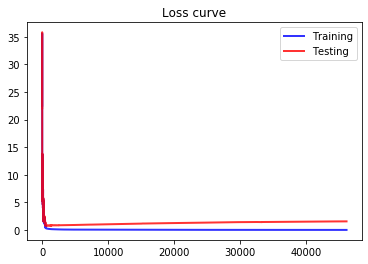

In [16]:
plt.title("Loss curve")
plot_1, = plt.plot(result_train["epoch"],result_train["loss"], color='b',linewidth=2,alpha=0.8)
plot_2, = plt.plot(result_test["epoch"],result_test["loss"], color='r',linewidth=2,alpha=0.8)
plt.legend([plot_1,plot_2],["Training","Testing"])


# Plot the accuracy curve

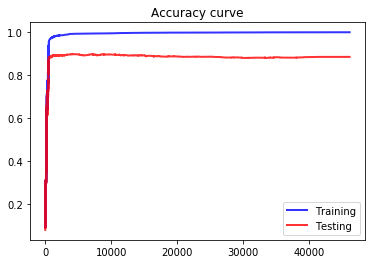

In [17]:
plt.title("Accuracy curve")
plot_1, = plt.plot(result_train["epoch"],result_train["acc"], color='b',linewidth=2,alpha=0.8)
plot_2, = plt.plot(result_test["epoch"],result_test["acc"], color='r',linewidth=2,alpha=0.8)
plt.legend([plot_1,plot_2],["Training","Testing"])

# Plot the accuracy value

In [12]:
print("Final Training Acc : {:.3f}%\nFinal Testing Acc : {:.3f}%".format(result_train["acc"][-1]*100,result_test["acc"][-1]*100))

Final Training Acc : 99.983%
Final Testing Acc : 88.500%


# Plot the classification example

## Correctly classified testing images

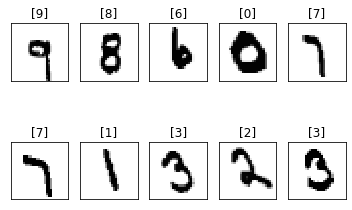

[[9], [8], [6], [0], [7], [7], [1], [3], [2], [3]]


In [18]:
show_example(list_correct_image,list_correct_label)
print(list_correct_label)

## Misclassified testing images

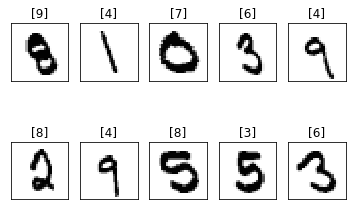

In [19]:
show_example(list_incorrect_image,list_incorrect_label)